<a href="https://colab.research.google.com/github/kesterlester/ColabForParityPaper3/blob/main/Parity_of_MNIST_with_controls.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://towardsdatascience.com/handwritten-digit-mnist-pytorch-977b5338e627

Introduction
------------
PyTorch provides the elegantly designed modules and classes, including
``torch.nn``, to help you create and train neural networks. An
``nn.Module`` contains layers, and a method ``forward(input)`` that
returns the ``output``.

Setup
-----
Before we begin, we need to install ``torch`` if it isn’t already
available.

::

   pip install torch





In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

In [2]:
%matplotlib inline
# visualization tools
%matplotlib inline
import matplotlib.pyplot as plt



In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

x = torch.tensor([[1,2,3],
                  [4,5,6],
                  [7,8,9]])
print(x)
np.pad(x, ((1, #top wrap pad
            1), #bot wrap pad
           (0, #left wrap pad
            0)), #right wrap pad
        mode='wrap')
print(torch.__version__)

tensor([[1, 2, 3],
        [4, 5, 6],
        [7, 8, 9]])
1.9.0+cu111


https://towardsdatascience.com/handwritten-digit-mnist-pytorch-977b5338e627

transforms.ToTensor() — converts the image into numbers, that are understandable by the system. It separates the image into three color channels (separate images): red, green & blue. Then it converts the pixels of each image to the brightness of their color between 0 and 255. These values are then scaled down to a range between 0 and 1. The image is now a Torch Tensor.
transforms.Normalize() — normalizes the tensor with a mean and standard deviation which goes as the two parameters respectively.
Now we finally download the data sets, shuffle them and transform each of them. We download the data sets and load them to DataLoader, which combines the data-set and a sampler and provides single- or multi-process iterators over the data-set.


In [4]:
#def my_pad(x):
#  return np.pad(x,  ((10, #top wrap pad
#            10), #bot wrap pad
#           (0, #left wrap pad
#            0)), #right wrap pad
#        mode='wrap')
  
def my_rotate_180(x):
  return torch.flip(x,[2,3])
  
def my_mirror_TB(x):
  return torch.flip(x,[2])

def my_mirror_LR(x):
  return torch.flip(x,[3])

def my_roll_down(x,distance):
  return torch.roll(x,distance,2)

def my_pad_TB(x, n):
  import torch.nn.functional as F
  return F.pad(input=x, pad=(0, #off the left
                             0, #off the right
                             n, #off the top
                             n), #off the bottom
                mode='circular')
  
def my_pad_bottom(x, n):
  import torch.nn.functional as F
  return F.pad(input=x, pad=(0, #off the left
                             0, #off the right
                             0, #off the top
                             n), #off the bottom
                mode='circular')

In [5]:
# Next four lines are workaround for bug reported in https://github.com/pytorch/vision/issues/3497#issuecomment-789983415
from six.moves import urllib
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)


# Here is where things SHOULD start
import torchvision
from torchvision import datasets, transforms

transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              #RemoveParityFromMNIST(),
                              ])

trainset = datasets.MNIST('PATH_TO_STORE_TRAINSET', download=True, train=True, transform=transform)
testset = datasets.MNIST('PATH_TO_STORE_TESTSET', download=True, train=False, transform=transform)
# The above stuff seems to contain actual data in a format I am not sure about.

# Feed it a data_loader. It will do two 'grabs' from each such data loader, and merge them.
# by pairwise combinations.
class Merging_Modifier:
  #  bias=0 generates a parity-free dataset.
  #  bias=1 generates a parity-full dataset.
  def __init__(self, bias, data_loader):
    if bias!=0 and bias!=1:
      raise ValueError
    self.bias = bias
    self.dataiter = iter(data_loader)

  def __iter__(self):
    return self

  def __next__(self):
    images1, labels1 = self.dataiter.next() # OK if raises StopIteration.
    images2, labels2 = self.dataiter.next() # OK if raises StopIteration.
    if images1.size() != images2.size():
      raise StopIteration
    if self.bias==0:
      return torch.max(images1,my_mirror_TB(images2)), labels1*10+labels2
    elif self.bias==1:
      return torch.max(images1,images2), labels1*10+labels2

# Feed it a data_loader. It will do a 'grab', and then randomly flip LR each element.
class Flipping_Modifier:
  def __init__(self, data_loader):
    self.dataiter = iter(data_loader)

  def __iter__(self):
    return self

  def __next__(self):
    images, labels = self.dataiter.next() # OK if raises StopIteration.
    num_images = images.size()[0]
    num_to_flip = np.random.binomial(num_images, 0.5)
    images_to_flip = images[:num_to_flip]
    images_to_keep = images[num_to_flip:]
    labels_to_flip = labels[:num_to_flip]
    labels_to_keep = labels[num_to_flip:]

    new_images = torch.cat([images_to_keep, my_mirror_LR(images_to_flip)], dim=0)
    new_labels = torch.cat([labels_to_keep, -labels_to_flip], dim=0)
    shuffled_indices = torch.randperm(num_images)

    shuffled_images = new_images[shuffled_indices]
    shuffled_labels = new_labels[shuffled_indices]
    return shuffled_images, shuffled_labels


class Group:
  def __init__(self,name, train=True, trainloader=None, testloader=None, net=None):
    self.name=name
    self.train=train
    if trainloader is not None:
      self.set_trainloader(trainloader)
    if testloader is not None:
      self.set_testloader(testloader)
    if net is not None:
      self.set_net(net)

  def get_some_test_images(self, max_images=None):
    dataiter = iter(self.testloader)
    images, labels = next(dataiter)
    if max_images is not None:
      images = images[:max_images]
    return images

  def get_some_train_images(self):
    dataiter = iter(self.trainloader)
    images, labels = next(dataiter)
    return images

  def set_trainloader(self, loader):
    self.trainloader = loader

  def set_testloader(self, loader):
    self.testloader = loader

  def set_net(self, net):
    self.net = net
    import torch.optim as optim
    self.optimizer = optim.SGD(self.net.parameters(), lr=0.001, momentum=0.9)


  def how_did_we_do_on(self, net_outputs, test):
    from math import sqrt
    num_positives=torch.count_nonzero(torch.gt(net_outputs,0).int()).item()
    num_negatives=torch.count_nonzero(torch.lt(net_outputs,0).int()).item()
    num_zeros=torch.count_nonzero(torch.eq(net_outputs,0).int()).item()
    num_total=num_positives+num_zeros+num_negatives
    poisson_p=num_positives/num_total
    poisson_q=1.0-poisson_p
    poisson_mean = num_total*poisson_p
    poisson_variance = num_total*poisson_p*poisson_q
    poisson_sd=sqrt(poisson_variance)

    fractional_mean = poisson_mean/num_total
    fractional_sd = poisson_sd/num_total
    
    if False:
      print("p ",poisson_p)
      print("q ",poisson_q)
      print("np ",poisson_mean)
      print("npq",poisson_variance)
      print("sqrt(npq)",poisson_sd)
      #print(num_positives, num_zeros, num_negatives, num_total)
    
    print("On",("test" if test else "train"),": Positive Fraction ",100*fractional_mean,"+-",100*fractional_sd,"%")
    #print(torch.transpose(x[:32],0,1))

  def how_did_we_do(self, test=True):
    self.how_did_we_do_on(self.net(self.get_some_test_images() if test else self.get_some_train_images()  ), test)
    #how_did_we_do_on(my_nn(my_rotate_180(images)))
    #how_did_we_do_on(my_nn(my_mirror_TB(images)))
    #how_did_we_do_on(my_nn(my_mirror_LR(images)))

batch_size=64

# The lines below create things (these "loaders") which can give us groups of (in this case)
# 64 labels and 64 pieces of data per "shot".  Apparently the order is random.
# One way of getting things out a batch of 64 goes like this:
#                 dataiter = iter(trainloader)
#                 images, labels = dataiter.next()

trainloader_MNIST = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True) 
testloader_MNIST = torch.utils.data.DataLoader(testset, batch_size=batch_size*16, shuffle=True)

trainloader_control_Achiral = Merging_Modifier(0,torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True))
testloader_control_Achiral = Merging_Modifier(0,torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True))

trainloader_control_Chiral = Merging_Modifier(1,torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True))
testloader_control_Chiral = Merging_Modifier(1,torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True))

trainloader_MNISTLR = Flipping_Modifier(torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True))
testloader_MNISTLR = Flipping_Modifier(torch.utils.data.DataLoader(testset, batch_size=batch_size*16, shuffle=True))

groups = {
   "Achiral" : Group("Achiral", train=False, trainloader=trainloader_control_Achiral, testloader=testloader_control_Achiral),
   "Chiral" : Group("Chiral", train=False, trainloader=trainloader_control_Chiral, testloader=testloader_control_Chiral),
   "MNIST" : Group("MNIST", train=False, trainloader=trainloader_MNIST, testloader=testloader_MNIST),
   "MNISTLR" : Group("MNISTLR", train=False, trainloader=trainloader_MNISTLR, testloader=testloader_MNISTLR),
}

#trainloaders = [
#                ("MNIST (train)",trainloader_MNIST),
#                ("Achiral LESTRIST (train)",trainloader_control_Achiral),
#                ("Chiral LESTRIST (train)",trainloader_control_Chiral),
#]
#testloaders = [
#                ("MNIST (test)", testloader_MNIST),
#                ("Achiral LESTRIST (test)",testloader_control_Achiral),
#                ("Chiral LESTRIST (test)",testloader_control_Chiral),
#]

#def iters_for(loaders):
#  return [ (loader[0], iter(loader[1])) for loader in loaders ]

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting PATH_TO_STORE_TRAINSET/MNIST/raw/train-images-idx3-ubyte.gz to PATH_TO_STORE_TRAINSET/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting PATH_TO_STORE_TRAINSET/MNIST/raw/train-labels-idx1-ubyte.gz to PATH_TO_STORE_TRAINSET/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting PATH_TO_STORE_TRAINSET/MNIST/raw/t10k-images-idx3-ubyte.gz to PATH_TO_STORE_TRAINSET/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting PATH_TO_STORE_TRAINSET/MNIST/raw/t10k-labels-idx1-ubyte.gz to PATH_TO_STORE_TRAINSET/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting PATH_TO_STORE_TESTSET/MNIST/raw/train-images-idx3-ubyte.gz to PATH_TO_STORE_TESTSET/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting PATH_TO_STORE_TESTSET/MNIST/raw/train-labels-idx1-ubyte.gz to PATH_TO_STORE_TESTSET/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting PATH_TO_STORE_TESTSET/MNIST/raw/t10k-images-idx3-ubyte.gz to PATH_TO_STORE_TESTSET/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting PATH_TO_STORE_TESTSET/MNIST/raw/t10k-labels-idx1-ubyte.gz to PATH_TO_STORE_TESTSET/MNIST/raw



In [6]:
#dataiters = iters_for(trainloaders)
#for it in dataiters:
#    print(it)

In [7]:
def tmp_test():
  for name, group in groups.items():
    dataiter = iter(group.trainloader)
    images, labels = next(dataiter)
    print(name, images.shape,labels.shape, images.size()[0])

tmp_test()

Achiral torch.Size([64, 1, 28, 28]) torch.Size([64]) 64
Chiral torch.Size([64, 1, 28, 28]) torch.Size([64]) 64
MNIST torch.Size([64, 1, 28, 28]) torch.Size([64]) 64
MNISTLR torch.Size([64, 1, 28, 28]) torch.Size([64]) 64


In [8]:
#my_pad_TB(images,10).size()

In [9]:
def my_shuffle(t):
  a=t[torch.randperm(t.size()[0])]
  return a

In [10]:
def mix_boring_symmetries(images, shuffle=True):
  t = torch.cat((
      images,
      my_roll_down(images,10),
      my_rotate_180(images),
      ), axis=0)
  if shuffle:
    t = my_shuffle(t)
  return t

def mix_all_symmetries(images, shuffle=True):
  segami = my_mirror_LR(images)
  t = torch.cat((
      images,
      my_roll_down(images,10),
      my_rotate_180(images),
      segami,
      my_roll_down(segami,10),
      my_rotate_180(segami),
      ), axis=0)
  if shuffle:
    t = my_shuffle(t)
  return t


# Image Showing Code

In [11]:
def show_some_images(images, max_width=8, max_height=8, batch_increase_factor=1):
  figure = plt.figure()
  width=max_width
  height=max_height
  while height*width>batch_size*batch_increase_factor:
    if height>width:
      height -= 1
    else:
      width -= 1
  num_of_images = height*width
  for index in range(1, num_of_images + 1):
    plt.subplot(height, width, index)
    plt.axis('off')
    plt.imshow(images[index-1].numpy().squeeze(), cmap='gray_r')


  

In [12]:
def show_some_train_images(tfm, max_width=8, max_height=8, batch_increase_factor=1):
  for name, group in groups.items():
    dataiter = iter(group.trainloader)
    print(name, "(train)")
    images, labels = next(dataiter)
    show_some_images(tfm(images), max_width=max_width, max_height=max_height, batch_increase_factor=batch_increase_factor)


# Debug Images



In [13]:
show_less_used_debug_images=False

In [14]:
if show_less_used_debug_images:
  print("Wrapping around by 10 at top and bottom")
  show_some_train_images(lambda images : my_pad_TB(images, 10), max_width=8, max_height=8)

Normal:
Achiral (train)
Chiral (train)
MNIST (train)
MNISTLR (train)


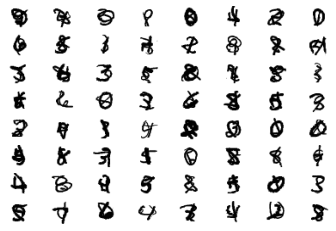

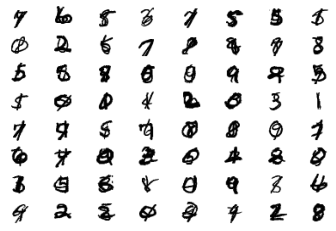

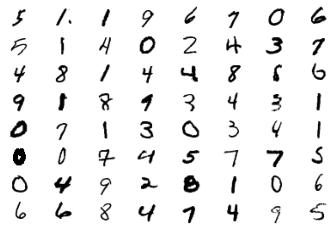

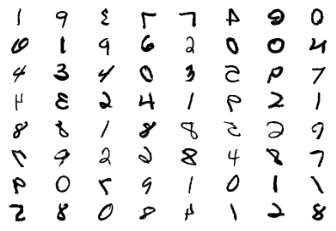

In [15]:
print("Normal:")
show_some_train_images(lambda images : images, max_width=8, max_height=8)

In [16]:
if show_less_used_debug_images:
  print("Roll down:")
  show_some_train_images(lambda images : my_roll_down(images, 10), max_width=8, max_height=8)

In [17]:
if show_less_used_debug_images:
  print("Mirrored left to right:")
  show_some_train_images(lambda images : my_mirror_LR(images), max_width=8, max_height=8)

In [18]:
if show_less_used_debug_images:
  print("Mirrored top to bottom:")
  show_some_train_images(lambda images : my_mirror_TB(images), max_width=8, max_height=8)

In [19]:
if show_less_used_debug_images:
  print("Rotated 180 degrees:")
  show_some_train_images(lambda images : my_rotate_180(images), max_width=8, max_height=8)

In [20]:
if show_less_used_debug_images:
  print("Mix boring symmetries:")
  show_some_train_images(lambda images : mix_boring_symmetries(images), max_width=8, max_height=8)

# Define and test Net

2. Define and intialize the neural network
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Our network will recognize images. We will use a process built into
PyTorch called convolution. Convolution adds each element of an image to
its local neighbors, weighted by a kernel, or a small matrix, that
helps us extract certain features (like edge detection, sharpness,
blurriness, etc.) from the input image.

There are two requirements for defining the ``Net`` class of your model.
The first is writing an ``__init__`` function that references
``nn.Module``. This function is where you define the fully connected
layers in your neural network.

Using convolution, we will define our model to take 1 input image
channel, and output match our target of 10 labels representing numbers 0
through 9. This algorithm is yours to create, we will follow a standard
MNIST algorithm.




We have finished defining our neural network, now we have to define how
our data will pass through it.

3. Specify how data will pass through your model
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

When you use PyTorch to build a model, you just have to define the
``forward`` function, that will pass the data into the computation graph
(i.e. our neural network). This will represent our feed-forward
algorithm.

You can use any of the Tensor operations in the ``forward`` function.




In [21]:
class Net(nn.Module):
    def __init__(self):
      super(Net, self).__init__()
      
      # Properties of the Image
      self.rowsCols=torch.tensor([28,28])
      self.kernel1_tuple=(4,4) # rows,cols
      self.kernel2_tuple=(14,6) # rows,cols
      self.kernel1_tensor=torch.tensor(self.kernel1_tuple)
      self.kernel2_tensor=torch.tensor(self.kernel2_tuple)

      # First 2D convolutional layer, taking in 1 input channel (B&W image),
      # outputting 32 convolutional features (output channels or colours, etc),
      # with a square kernel size of 3 and a stride of 1.
    
      self.conv1 = nn.Conv2d(1, 32, self.kernel1_tuple, 1)
      # Second 2D convolutional layer, taking in the 32 input layers,
      # outputting 64 convolutional features, with a square kernel size of 3
      self.conv2 = nn.Conv2d(32, 64, self.kernel2_tuple, 1)


      # Designed to ensure that adjacent pixels are either all 0s or all active
      # with an input probability
      self.dropout1 = nn.Dropout2d(0.25)
      self.dropout2 = nn.Dropout2d(0.5)

      # First fully connected layer
      #self.fc1 = nn.Linear(9216, 128) # for kernel size 3
      #self.fc1 = nn.Linear(7744, 128)  # for kernel size 4
      self.fc1 = nn.Linear(640, 128)  # for kernel size 4
      # Second fully connected layer that outputs our 10 labels
      self.fc2 = nn.Linear(128, 1)

      #self.conv1 = nn.Conv2d(1, 32, 3, 1)
      #self.conv2 = nn.Conv2d(32, 64, 3, 1)
      #self.dropout2 = nn.Dropout2d(0.5)
      #self.fc1 = nn.Linear(9216, 128)
      #self.dropout1 = nn.Dropout2d(0.25)
      #self.fc2 = nn.Linear(128, 10)

    # x represents our data
    def forward(self, x):
      answer = self.forward_worker(x)
      answer = answer + self.forward_worker(my_rotate_180(x))
      answer = answer - self.forward_worker(my_mirror_TB(x))
      answer = answer - self.forward_worker(my_mirror_LR(x))
      #return F.hardtanh(answer)
      #return F.softsign(answer)
      return answer/4.0


    # x represents our data
    def forward_worker(self, x):
      # Note that I am only intending here to flip 28x28 images, but it seems that we are
      # given rank 4 tensors even if there is only one image.  This seems to be (at least in part)
      # so that we can be given (a) multiple images, and (b) each image can have different channels (e.g. r.g.b).
      # It seems that the multi-imaging is for batches, while the multi-channeling is for colours.

      #MMM rowsCols = self.rowsCols
      #MMM print("1. Initial dims should be N, 1,",rowsCols,": ", x.size())
      # Pad data top and bottom so that can treat phi periodically.
      # Note that adding things top and bottom increase the ROWS, and 
      # so the padding size is related to the number of ROWS in first_2d_kernel
      x = my_pad_bottom(x, self.kernel1_tuple[0]-1)  # 0=rows
      #MMM rowsCols += torch.tensor([self.kernel1_tuple[0]-1, 0])
      #MMM print("2. Should have grown to   N,32,",rowsCols,": ", x.size())
      # Pass x data through conv1
      x = self.conv1(x)
      #MMM rowsCols += torch.tensor((1,1)) - self.kernel1_tensor
      #MMM print("3. Should be back at      N,32,",rowsCols,": ", x.size())
      # Use the rectified-linear activation function over x
      x = F.relu(x)

      # Pad data top and bottom so that can treat phi periodically.
      # Note that adding things top and bottom increase the ROWS, and 
      # so the padding size is related to the number of ROWS in second_2d_kernel
      x = my_pad_bottom(x, self.kernel2_tuple[0]-1)  # 0=rows
      #MMM rowsCols += torch.tensor([self.kernel2_tuple[0]-1, 0])
      #MMM print("4. Should have grown to   N,32,",rowsCols,": ", x.size())
      # Pass x data through conv2
      x = self.conv2(x)
      #MMM rowsCols += torch.tensor((1,1)) - self.kernel2_tensor
      #MMM print("5. Should be back at      N,64,",rowsCols,": ", x.size())
      # Use the rectified-linear activation function over x
      x = F.relu(x)
      #MMM print("")
      #MMM 

      # Run max pooling over *ALL* phi and some eta.
      # Note that this step (combined with the previous convolutions over phi)
      # is what makes the subsequent steps in the net invariant WRT phi-rolling.
           
      # To make this step work, it is important that the number of 
      # rows in our data at this point is
      # important that this is also the number
      # of phi-bins in our data.  
      # 2 is the pooling in eta, and its value is
      # not so critical. Therefore we make the following assertion
      assert self.rowsCols[0].item() == x.size()[2]
      # Now do what we actually promised to do:
      x = F.max_pool2d(x, (self.rowsCols[0].item(), 2)) 

      # Pass data through dropout1
      #x = self.dropout1(x)
      # Flatten x with start_dim=1
      x = torch.flatten(x, 1)
      # Pass data through fc1
      #MMM print("5. is now: ", x.size())
      #MMM 
      x = self.fc1(x)
      x = F.relu(x)
      #x = self.dropout2(x)
      x = self.fc2(x)

      return torch.sum(x, dim=1) # because the 128->1 layer gives [1] not 1.

      # Apply softmax to x 
      #output = F.log_softmax(x, dim=1)
      #return torch.einsum("xi,i->x",output,torch.tensor([1.0,-1.0]))


for group in groups.values():
  group.set_net(Net())
 

In [22]:
for group in groups.values():
  print(group.name, group.net)

Achiral Net(
  (conv1): Conv2d(1, 32, kernel_size=(4, 4), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(14, 6), stride=(1, 1))
  (dropout1): Dropout2d(p=0.25, inplace=False)
  (dropout2): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=640, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
)
Chiral Net(
  (conv1): Conv2d(1, 32, kernel_size=(4, 4), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(14, 6), stride=(1, 1))
  (dropout1): Dropout2d(p=0.25, inplace=False)
  (dropout2): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=640, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
)
MNIST Net(
  (conv1): Conv2d(1, 32, kernel_size=(4, 4), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(14, 6), stride=(1, 1))
  (dropout1): Dropout2d(p=0.25, inplace=False)
  (dropout2): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=640, out_features=128, bias=True)
  (fc2): 

4. [Optional] Pass data through your model to test
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

To ensure we receive our desired output, let’s test our model by passing
some random data through it.




In [23]:
# The following line gives num_ran_images random, 1-colour, 28x28 images
num_ran_images=10
random_data = torch.rand((num_ran_images, 1, 28, 28))
test_images = groups["MNIST"].get_some_test_images(max_images=16)
         #iter(testloader_MNIST).next()
#print("RD",random_data)
#print("TI",test_images)

my_nn_test = Net()
print("Net called with "+str(num_ran_images)+" images gives:")
print (my_nn_test(random_data))
print("Net called with some test data images gives:")
print (my_nn_test(test_images))
print("Net called with some down-rolled data images gives:")
print (my_nn_test(my_roll_down(test_images,10)))
print("Net called with some down-rolled and rotated data images gives:")
print (my_nn_test(my_rotate_180(my_roll_down(test_images,10))))

moo = my_nn_test(random_data)
print ("moo=",moo)
print ("var(moo)",torch.var(moo))
print ("stdDev(moo)",torch.std(moo))

print ("std_mean(moo)",torch.std_mean(moo))

Net called with 10 images gives:


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


tensor([-0.0006, -0.0028,  0.0031,  0.0015,  0.0006, -0.0019,  0.0018, -0.0025,
        -0.0031,  0.0015], grad_fn=<DivBackward0>)
Net called with some test data images gives:
tensor([-0.0037, -0.0090,  0.0001, -0.0035,  0.0041, -0.0030,  0.0004, -0.0037,
        -0.0087, -0.0020, -0.0028, -0.0078,  0.0042, -0.0016,  0.0059, -0.0028],
       grad_fn=<DivBackward0>)
Net called with some down-rolled data images gives:
tensor([-0.0037, -0.0090,  0.0001, -0.0035,  0.0041, -0.0030,  0.0004, -0.0037,
        -0.0087, -0.0020, -0.0028, -0.0078,  0.0042, -0.0016,  0.0059, -0.0028],
       grad_fn=<DivBackward0>)
Net called with some down-rolled and rotated data images gives:
tensor([-0.0037, -0.0090,  0.0001, -0.0035,  0.0041, -0.0030,  0.0004, -0.0037,
        -0.0087, -0.0020, -0.0028, -0.0078,  0.0042, -0.0016,  0.0059, -0.0028],
       grad_fn=<DivBackward0>)
moo= tensor([-0.0006, -0.0028,  0.0031,  0.0015,  0.0006, -0.0019,  0.0018, -0.0025,
        -0.0031,  0.0015], grad_fn=<DivBackward

Each number in this resulting tensor equates to the prediction of the
label the random tensor is associated to.

Congratulations! You have successfully defined a neural network in
PyTorch.


Take a look at these other recipes to continue your learning:

- `What is a state_dict in PyTorch <https://pytorch.org/tutorials/recipes/recipes/what_is_state_dict.html>`__
- `Saving and loading models for inference in PyTorch <https://pytorch.org/tutorials/recipes/recipes/saving_and_loading_models_for_inference.html>`__



https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

In [24]:
#for i, data in enumerate(trainloader_MNIST, 0):
#        # get the inputs; data is a list of [inputs, labels]
#        if i<2:
#        inputs, labels = data
#            print (i,labels)

In [25]:
#inputs,labels = iter(trainloader_MNIST).next()

In [26]:
#torch.sum(my_nn_test(inputs))

# Status without training

In [27]:
def show_status_for_groups(message, attempts=1):
  #for name, group in groups.items():
  #  print(message,group.name)#, group.net)
  #  group.how_did_we_do()
  #
  #print()

  for _ in range(attempts):
    for group in groups.values():
      print(message,group.name)#, group.net)
      group.how_did_we_do()
      
    print()


In [28]:
show_status_for_groups("Without training", attempts=0)

In [29]:
#my_single_scalar = torch.sum(my_nn(inputs))
##my_single_scalar = my_nn(inputs)
#my_negative_scalar = -my_single_scalar
#optimizer.zero_grad()
#my_negative_scalar.backward()
#optimizer.step()

In [30]:
def train_group(group):  

    print('Before Training',group.name)
    group.how_did_we_do()

    for epoch in range(1):  # loop over the dataset multiple times

      running_loss = 0.0
      for i, data in enumerate(group.trainloader, 0):
        if i<50:
          # get the inputs; data is a list of [inputs, labels]
          inputs, labels = data

          # zero the parameter gradients
          group.optimizer.zero_grad()

          # forward + backward + optimize
          #mean_W = torch.sum(my_nn(inputs))
          #stdDev_W = torch.std(my_nn(inputs))
          stdDev_W, mean_W = torch.std_mean(group.net(inputs))

          thing_to_minimise = -mean_W/stdDev_W


          thing_to_minimise.backward()
          group.optimizer.step()


          # print statistics
          running_loss += (-thing_to_minimise).item()
          print_every=1
          if i % print_every == print_every-1:    # print every 2000 mini-batches
              print('[%d, %5d] loss: %.3f' %
                    (epoch + 1, i + 1, running_loss/print_every ))
              running_loss = 0.0
              group.how_did_we_do()
    print('Finished Training',group.name)
    group.how_did_we_do()
    




# Train Net (and save) or Load saved Nets:

In [31]:
def train_save_or_load_nets(train_all_nets = False):
  from os import makedirs
  makedirs('NETS',exist_ok=True)


  for name, group in groups.items():  
    PATH = 'NETS/'+name+'.pth'
    
    train_this_group = train_all_nets or group.train

    if train_this_group:
      train_group(group)
      torch.save(group.net.state_dict(), PATH)
    else:  # Load this group from file
      sh = "wget -O "+PATH+" https://www.hep.phy.cam.ac.uk/~lester/datasets/NETS/"+name+".pth"
      with open('script.sh', 'w') as file:
        file.write(sh)

      !bash script.sh
      group.net.load_state_dict(torch.load(PATH))

train_save_or_load_nets(train_all_nets = False)

--2021-10-31 18:48:26--  https://www.hep.phy.cam.ac.uk/~lester/datasets/NETS/Achiral.pth
Resolving www.hep.phy.cam.ac.uk (www.hep.phy.cam.ac.uk)... 131.111.66.28, 2a05:b400:104:100:5054:ff:fe00:421c
Connecting to www.hep.phy.cam.ac.uk (www.hep.phy.cam.ac.uk)|131.111.66.28|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1021583 (998K)
Saving to: ‘NETS/Achiral.pth’

NETS/Achiral.pth    100%[===================>] 997.64K  1.63MB/s    in 0.6s    

2021-10-31 18:48:27 (1.63 MB/s) - ‘NETS/Achiral.pth’ saved [1021583/1021583]

--2021-10-31 18:48:27--  https://www.hep.phy.cam.ac.uk/~lester/datasets/NETS/Chiral.pth
Resolving www.hep.phy.cam.ac.uk (www.hep.phy.cam.ac.uk)... 131.111.66.28, 2a05:b400:104:100:5054:ff:fe00:421c
Connecting to www.hep.phy.cam.ac.uk (www.hep.phy.cam.ac.uk)|131.111.66.28|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1021583 (998K)
Saving to: ‘NETS/Chiral.pth’

NETS/Chiral.pth     100%[===================>] 997.64K  1

In [32]:
show_status_for_groups("After training", attempts=3)

After training Achiral
On test : Positive Fraction  43.75 +- 6.200979635307634 %
After training Chiral
On test : Positive Fraction  92.1875 +- 3.354602351038607 %
After training MNIST
On test : Positive Fraction  91.2109375 +- 0.8847992745373221 %
After training MNISTLR
On test : Positive Fraction  48.2421875 +- 1.5615341062103785 %

After training Achiral
On test : Positive Fraction  40.625 +- 6.139153767774106 %
After training Chiral
On test : Positive Fraction  90.625 +- 3.6435074426128184 %
After training MNIST
On test : Positive Fraction  90.72265625 +- 0.906608370922578 %
After training MNISTLR
On test : Positive Fraction  48.73046875 +- 1.5619962595502268 %

After training Achiral
On test : Positive Fraction  42.1875 +- 6.173234620812151 %
After training Chiral
On test : Positive Fraction  93.75 +- 3.0257682392245444 %
After training MNIST
On test : Positive Fraction  91.11328125 +- 0.8892248340694155 %
After training MNISTLR
On test : Positive Fraction  50.390625 +- 1.562452315

Show some test-set images:

In [33]:
def greyscale_an_image(images):
    # Assumes images has dimension (numImages, 1(grey-chan), wid, height).
    # Assumes input image pixels have been scaled to go from -1 to 1 with
    # white being -1 and black being +1.

    # Convert so that image pixels go from 0 to 1 with white ending up as 1
    # and black ending up as 0.
    images_in_0_1 = (1-images)/2
    return images_in_0_1 #torch.einsum("igxy,ic->icxy",images_in_0_1,rgb_tints)

def tint_an_image(images,rgb_tints):
    # Assumes images has dimension (numImages, 1(grey-chan), wid, height).
    # Assumes input image pixels have been scaled to go from -1 to 1 with
    # white being -1 and black being +1.

    # Convert so that image pixels go from 0 to 1 with white ending up as 1
    # and black ending up as 0.
    images_in_0_1 = (1-images)/2
    return torch.einsum("igxy,ic->icxy",images_in_0_1,rgb_tints)

def images_to_net_tints(net,images):

    # Aim is to return:
    #     a green tint to a maximally right-handed image,
    #     a yellow tint to a neutral image,
    #     a red tint to a maximally left-handed image.

    # Interpolation is piecewise linear in those two regions.

    
    vals = net(images)
    stdDev = torch.std(vals)
    # Strictly the following are not in [-1,1] .... but presumably they are not far off
    vals_in_m1_p1 = vals / (2.0*stdDev)

    right_handed_vals =   vals_in_m1_p1 [:,None]
    left_handed_vals  = (-vals_in_m1_p1)[:,None]
    is_right_handed = torch.sum(torch.ge(right_handed_vals, 0).int(),dim=1) # (because the last layer gives [1] not 1.)
    is_left_handed  = torch.sum(torch.ge( left_handed_vals, 0).int(),dim=1) # (because the last layer gives [1] not 1.)
    
    # Note that the colours as calculated should not over-saturate

    right_handed_colour=torch.tensor([0,1,0])[None,:]  # green
    neutral_colour     =torch.tensor([1,1,0])[None,:]  # yellow
    left_handed_colour =torch.tensor([1,0,0])[None,:]  # red

    R_colour =(   right_handed_vals * right_handed_colour + 
               (1-right_handed_vals)*      neutral_colour)
    L_colour =(   left_handed_vals  *left_handed_colour + 
               (1-left_handed_vals) *    neutral_colour)
    
    piecewise_interpolated_color = (
        torch.einsum("ic,i->ic",R_colour, is_right_handed) +
        torch.einsum("ic,i->ic",L_colour, is_left_handed)
    )
    return piecewise_interpolated_color

def images_to_untinted_images(group,images):
    return greyscale_an_image(images)

def images_to_tinted_images(group,images): 
    # Assumes all images are greyscale.  
    return tint_an_image(images, images_to_net_tints(group.net,images))

#print(images_to_tinted_images(images))

In [34]:
def imshow(img, filename=None):
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.detach().numpy()
    #npimg = tint_numpy_image(npimg, [1.0, 0.0, 0.0])
    img = np.transpose(npimg, (1, 2, 0))
    plt.imshow(img)
    if filename is not None:
      img = np.clip(img, 0, 1)
      plt.imsave(filename, img)
    plt.show()



## Move to test dataset

In [35]:
#dataiter = iter(testloader)
#images, labels = dataiter.next()

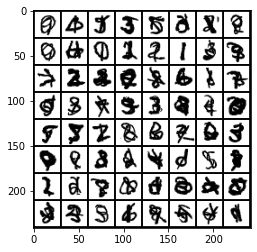

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


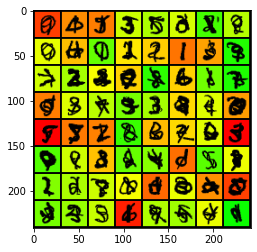

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


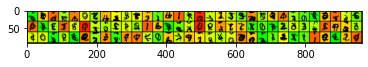

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


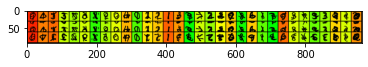

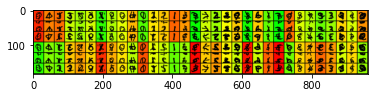

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


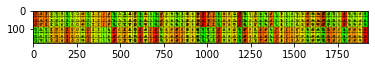

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


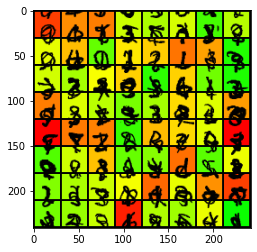

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


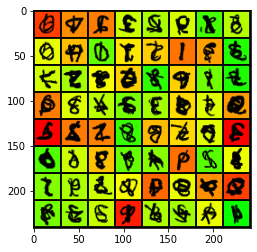

On test : Positive Fraction  42.1875 +- 6.173234620812151 %


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


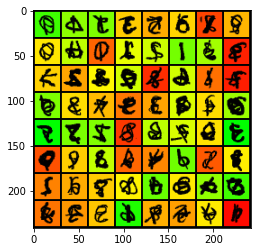

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


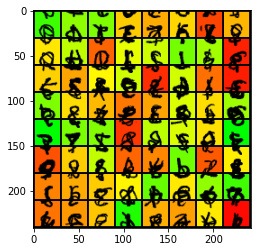

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


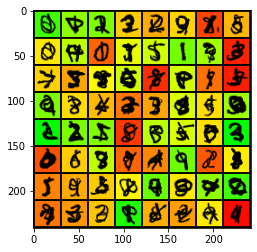

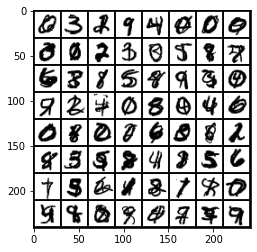

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


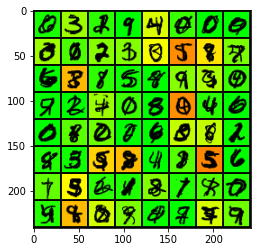

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


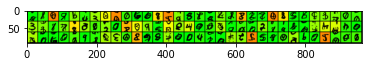

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


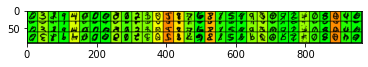

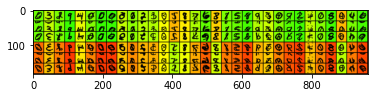

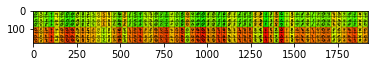

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


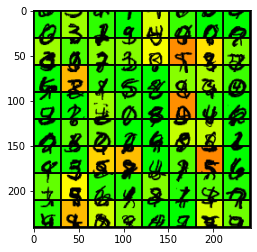

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


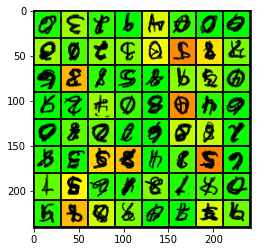

On test : Positive Fraction  89.0625 +- 3.901364131921519 %


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


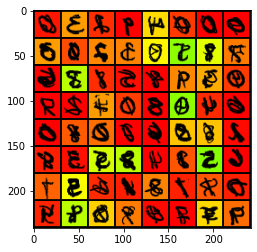

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


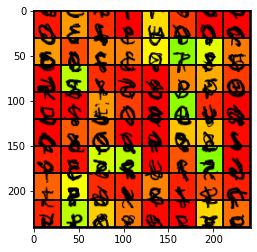

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


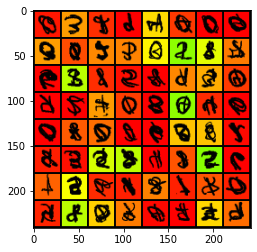

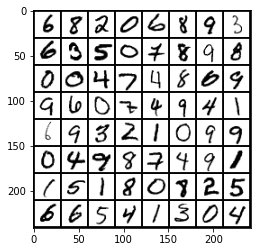

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


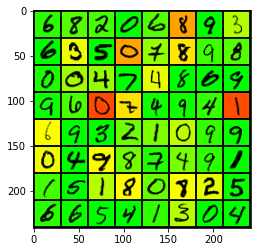

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


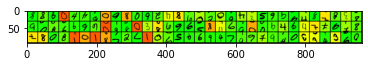

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


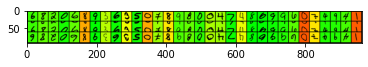

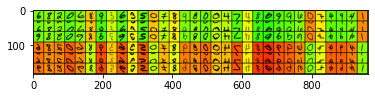

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


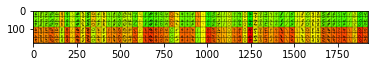

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


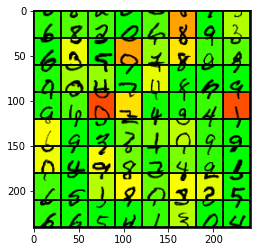

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


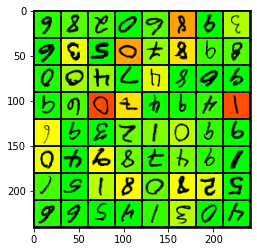

On test : Positive Fraction  89.94140625 +- 0.939936452084651 %


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


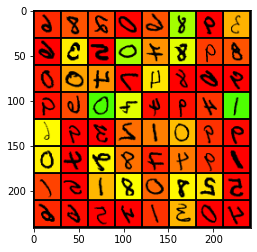

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


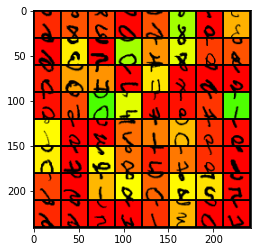

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


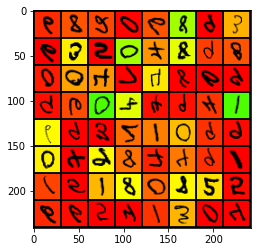

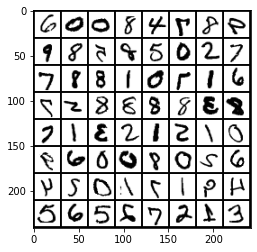

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


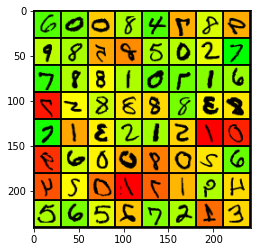

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


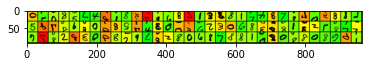

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


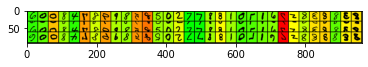

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


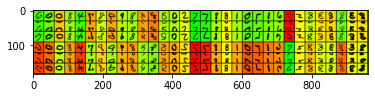

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


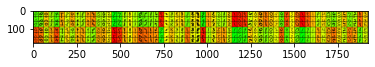

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


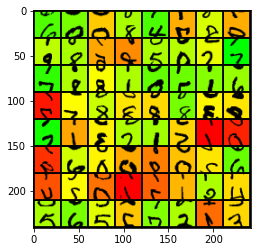

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


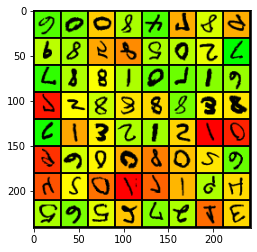

On test : Positive Fraction  50.5859375 +- 1.5623927079556978 %


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


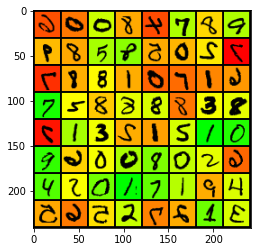

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


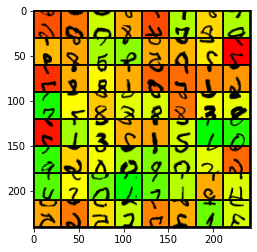

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


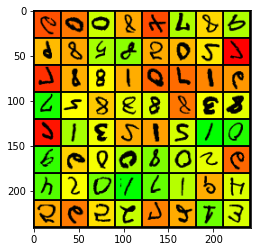

In [36]:
#images, labels = dataiter.next()

def make_some_plots():
  for group in groups.values():
    name = group.name
    images = group.get_some_test_images(max_images=64)

    imshow(torchvision.utils.make_grid(images_to_untinted_images(group,images)), filename=name+"_normal_8x8_untinted.png")
    imshow(torchvision.utils.make_grid(images_to_tinted_images(group,images)), filename=name+"_normal_8x8.png")
    imshow(torchvision.utils.make_grid(images_to_tinted_images(group,mix_boring_symmetries(images[:32], shuffle=True )), nrow=32))
    imshow(torchvision.utils.make_grid(images_to_tinted_images(group,mix_boring_symmetries(images[:32], shuffle=False)), nrow=32))
    imshow(torchvision.utils.make_grid(images_to_tinted_images(group,mix_all_symmetries(images[:32], shuffle=False)), nrow=32), filename=name+"_mixture.png")
    imshow(torchvision.utils.make_grid(images_to_tinted_images(group,mix_all_symmetries(images[:64], shuffle=False)), nrow=64), filename=name+"_long_mixture.png")
    imshow(torchvision.utils.make_grid(my_roll_down(images_to_tinted_images(group,images),10)))
    imshow(torchvision.utils.make_grid(my_rotate_180(images_to_tinted_images(group,images))))
    group.how_did_we_do()
    #images, labels = dataiter.next()
    #imshow(torchvision.utils.make_grid(images_to_tinted_images(group,my_rotate_180(images))))

    #images, labels = dataiter.next()
    imshow(torchvision.utils.make_grid(images_to_tinted_images(group,my_mirror_LR(images))), filename=name+"_LR_8x8.png")
    imshow(torchvision.utils.make_grid(images_to_tinted_images(group,my_roll_down(my_mirror_LR(images),10))))
    imshow(torchvision.utils.make_grid(my_rotate_180(images_to_tinted_images(group,my_mirror_LR(images)))))
    #print('GroundTruth: ', ' '.join('%5s' % labels[j] for j in range(4)))

make_some_plots()